# Data Preparation #

1. Bristol Crime data(Jan 2025 - Oct 2025): Police.uk Monthly Incidents
2. Socioecomomic data(2025): Indices of Deprivation 2025
3. Geospatial Data: LSOA 2021 Boundaries (Precise)

### Libraries

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

# Set visual style for plots
sns.set_theme(style="whitegrid")

In [28]:
# --- STEP 1: LOAD RAW POLICE DATA ---
path = "raw_data/police_files/" 
all_files = glob.glob(path + "*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

raw_crime = pd.concat(li, axis=0, ignore_index=True)

print(f"Total Raw Rows: {len(raw_crime)}")

Total Raw Rows: 167739


#### Clean Police Data

In [29]:
raw_crime.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,5b3b243f3ae69b761588f65caefe62454587b15576ed55...,2025-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-1.084621,53.251666,On or near Limetree Avenue,E01033769,Bassetlaw 014F,Violence and sexual offences,Action to be taken by another organisation,NaN
1,1673f50aa688f77cc735d07f47a4f8fcff38d5ebcb70ed...,2025-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511824,51.411782,On or near Westfield Close,E01014399,Bath and North East Somerset 001A,Criminal damage and arson,Status update unavailable,NaN
2,cf50d7824b02ca548125204807e34491d14de60b1812e7...,2025-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.508867,51.416147,On or near St Francis Road,E01014399,Bath and North East Somerset 001A,Violence and sexual offences,Local resolution,NaN
3,63e97874e46f7c886d2d9444741fa4651dac32af835e80...,2025-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.508867,51.416147,On or near St Francis Road,E01014399,Bath and North East Somerset 001A,Violence and sexual offences,Unable to prosecute suspect,NaN
4,7d93e2987187429aee7de3cc7d1042f7fe47086821296f...,2025-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.508867,51.416147,On or near St Francis Road,E01014399,Bath and North East Somerset 001A,Violence and sexual offences,Unable to prosecute suspect,NaN


In [30]:


# 1. Filter for columns we need
crime_df = raw_crime[['Month', 'Longitude', 'Latitude', 'LSOA code', 'LSOA name', 'Crime type']].copy()

# 2. Drop rows where location is missing (we can't map them)
crime_df = crime_df.dropna(subset=['Longitude', 'Latitude'])

# 3. Rename columns for easier coding later
crime_df = crime_df.rename(columns={'LSOA code': 'LSOA21CD', 'LSOA name': 'LSOA21NM'})

print(f"Cleaned Rows: {len(crime_df)}")
crime_df.head()

Cleaned Rows: 148396


,Month,Longitude,Latitude,LSOA21CD,LSOA21NM,Crime type
0,2025-01,-1.084621,53.251666,E01033769,Bassetlaw 014F,Violence and sexual offences
1,2025-01,-2.511824,51.411782,E01014399,Bath and North East Somerset 001A,Criminal damage and arson
2,2025-01,-2.508867,51.416147,E01014399,Bath and North East Somerset 001A,Violence and sexual offences
3,2025-01,-2.508867,51.416147,E01014399,Bath and North East Somerset 001A,Violence and sexual offences
4,2025-01,-2.508867,51.416147,E01014399,Bath and North East Somerset 001A,Violence and sexual offences


In [31]:
# --- STEP 3: LOAD & CLEAN SOCIOECONOMIC DATA ---

# Load Bristol IMD file
imd_df = pd.read_csv("raw_data/Indices_of_Multiple_Deprivation_2025.csv")

# Select only the columns we need for the analysis
cols_to_keep = [
    'LSOA21CD', 
    'LSOA21NM', 
    'LSOA21LN', 
    'IMDScore', 
    'Income', 
    'Employment', 
    'EducationSkillsTrainingScore', 
    'CrimeScore',
    'LivingEnvironmentScore',  
    'POP2022Total'
]

master_df = imd_df[cols_to_keep].copy()

# Rename EducationSkillsTrainingScore to EducationScore for simplicity
master_df = master_df.rename(columns={
    'EducationSkillsTrainingScore': 'EducationScore'
})

print(f"Master Data Rows: {len(master_df)}")
display(master_df.head())

# FILTER CRIME DATA TO BRISTOL
# Get the list of valid LSOA codes for Bristol from the master_df
valid_bristol_codes = master_df['LSOA21CD'].unique()

# Filter the crime_df to keep only rows where the LSOA code exists in our Bristol list
bristol_crime_df = crime_df[crime_df['LSOA21CD'].isin(valid_bristol_codes)].copy()

print(f"Original Crime Rows: {len(crime_df)}")
print(f"Filtered Bristol Crime Rows: {len(bristol_crime_df)}")

Master Data Rows: 268


,LSOA21CD,LSOA21NM,LSOA21LN,IMDScore,Income,Employment,EducationScore,CrimeScore,LivingEnvironmentScore,POP2022Total
0,E01014674,Bristol 027B,Burchells Green,22.04,24.9,14.1,32.1,0.3,17.9,1749
1,E01014485,Bristol 058A,Mina Road,21.10,22.1,11.1,22.6,0.3,48.5,1975
2,E01014486,Bristol 058C,St Agnes,35.23,32.8,19.0,25.5,1.4,46.8,2759
3,E01014487,Bristol 020A,Cromwell Road,8.32,7.7,5.5,1.0,-0.1,43.8,2038
4,E01014488,Bristol 058B,Upper Montpelier,17.90,21.4,12.9,11.0,0.4,33.4,2108


Original Crime Rows: 148396
Filtered Bristol Crime Rows: 57241


#### Merge the data

In [32]:
# --- STEP 5: AGGREGATION & DATA MERGING ---

# 1. Count crimes per LSOA
lsoa_crime_counts = bristol_crime_df['LSOA21CD'].value_counts().reset_index()
lsoa_crime_counts.columns = ['LSOA21CD', 'Period_Total_Crimes']

# 2. Left Join to Master Data (keeps areas with 0 crime)
master_df = pd.merge(master_df, lsoa_crime_counts, on='LSOA21CD', how='left')

# 3. Replace NaN with 0 for calculation
master_df['Period_Total_Crimes'] = master_df['Period_Total_Crimes'].fillna(0)

# 4. Calculate Crime Rate (Crimes per 1,000 people)
master_df['Crime_Rate'] = (master_df['Period_Total_Crimes'] / master_df['POP2022Total']) * 1000

# Verify the merge
print(f"Merged Data Shape: {master_df.shape}")
display(master_df.head())



Merged Data Shape: (268, 12)


,LSOA21CD,LSOA21NM,LSOA21LN,IMDScore,Income,Employment,EducationScore,CrimeScore,LivingEnvironmentScore,POP2022Total,Period_Total_Crimes,Crime_Rate
0,E01014674,Bristol 027B,Burchells Green,22.04,24.9,14.1,32.1,0.3,17.9,1749,147,84.048027
1,E01014485,Bristol 058A,Mina Road,21.10,22.1,11.1,22.6,0.3,48.5,1975,208,105.316456
2,E01014486,Bristol 058C,St Agnes,35.23,32.8,19.0,25.5,1.4,46.8,2759,383,138.818412
3,E01014487,Bristol 020A,Cromwell Road,8.32,7.7,5.5,1.0,-0.1,43.8,2038,80,39.254171
4,E01014488,Bristol 058B,Upper Montpelier,17.90,21.4,12.9,11.0,0.4,33.4,2108,219,103.889943


###  APP OPTIMISATION & EXPORT 


In [33]:

# 1. Pre-calculate Static Metrics
# We calculate the default 'Annual Crime Rate' here to reduce load time in the live app.
# This ensures the map has data to show immediately upon startup.
master_df['Crime_Rate'] = (master_df['Period_Total_Crimes'] / master_df['POP2022Total']) * 1000
master_df['Crime_Rate'] = master_df['Crime_Rate'].fillna(0)

# 2. Date Formatting
# Ensure the date column is standard to prevent sorting errors in the dashboard slider.
bristol_crime_df['Month'] = pd.to_datetime(bristol_crime_df['Month'])

In [34]:
# 3. Export
# Save these optimised files
bristol_crime_df.to_csv('app_data_incidents.csv', index=False)
master_df.to_csv('app_data_master.csv', index=False)

print("Optimised app data exported successfully.")

Optimised app data exported successfully.


#### Data for Pubs/Restaurants

In [35]:
#  NIGHT-TIME ECONOMY DATA PREP ---

import numpy as np

#  Load Data
food_df = pd.read_csv("raw_data/Food_Hygiene_Ratings.csv")

# Coordinate Conversion Function
# The raw data uses British National Grid (X/Y). We need Latitude/Longitude for the map.
# This function performs the mathematical transformation (OSGB36 to WGS84).
def get_lat_lon(E, N):
    # E, N are Easting and Northing
    a, b = 6377563.396, 6356256.909  # Airy 1830 ellipsoid constants
    F0 = 0.9996012717
    lat0 = 49 * np.pi / 180
    lon0 = -2 * np.pi / 180
    N0, E0 = -100000, 400000
    e2 = 1 - (b**2) / (a**2)
    n = (a - b) / (a + b)

    lat = lat0
    M = 0
    while True:
        lat = (N - N0 - M) / (a * F0) + lat
        M = b * F0 * ((1 + n + (5/4)*n**2 + (5/4)*n**3) * (lat - lat0) -
                      (3*n + 3*n**2 + (21/8)*n**3) * np.sin(lat - lat0) * np.cos(lat + lat0) +
                      ((15/8)*n**2 + (15/8)*n**3) * np.sin(2*(lat - lat0)) * np.cos(2*(lat + lat0)) -
                      (35/24)*n**3 * np.sin(3*(lat - lat0)) * np.cos(3*(lat + lat0)))
        if (N - N0 - M) < 0.00001: break

    tan_lat = np.tan(lat)
    sec_lat = 1. / np.cos(lat)
    nu = a * F0 * (1 - e2 * np.sin(lat)**2)**-0.5
    rho = a * F0 * (1 - e2)**-1 * (1 - e2 * np.sin(lat)**2)**1.5
    eta2 = nu / rho - 1

    dE = (E - E0)
    VII = tan_lat / (2 * rho * nu)
    VIII = tan_lat / (24 * rho * nu**3) * (5 + 3 * tan_lat**2 + eta2 - 9 * tan_lat**2 * eta2)
    IX = tan_lat / (720 * rho * nu**5) * (61 + 90 * tan_lat**2 + 45 * tan_lat**4)
    X = sec_lat / nu
    XI = sec_lat / (6 * nu**3) * (nu / rho + 2 * tan_lat**2)
    XII = sec_lat / (120 * nu**5) * (5 + 28 * tan_lat**2 + 24 * tan_lat**4)
    XIIA = sec_lat / (5040 * nu**7) * (61 + 662 * tan_lat**2 + 1320 * tan_lat**4 + 720 * tan_lat**6)

    lat_out = lat - VII * dE**2 + VIII * dE**4 - IX * dE**6
    lon_out = lon0 + X * dE - XI * dE**3 + XII * dE**5 - XIIA * dE**7

    return np.degrees(lat_out), np.degrees(lon_out)

# Filter for Relevant Business Types
# places that serve alcohol or late-night food.
target_types = [
    'Pub/bar/nightclub', 
    'Restaurant/Cafe/Canteen', 
    'Takeaway/sandwich shop'
]
pubs_df = food_df[food_df['BUSINESS_TYPE'].isin(target_types)].copy()

# Apply Conversion
print("Converting coordinates... this may take a moment.")
pubs_df['Latitude'], pubs_df['Longitude'] = zip(*pubs_df.apply(
    lambda row: get_lat_lon(row['X'], row['Y']), axis=1
))

# Clean and Export
# Select only the columns needed for the Dashboard
cleaned_pubs = pubs_df[['BUSINESS_NAME', 'BUSINESS_TYPE', 'Latitude', 'Longitude']]

# Save to CSV
cleaned_pubs.to_csv('bristol_pubs_restaurants.csv', index=False)

print(f"Success! Processed {len(cleaned_pubs)} venues.")
print("File saved as: bristol_pubs_restaurants.csv")
cleaned_pubs.head()

Converting coordinates... this may take a moment.
Success! Processed 2071 venues.
File saved as: bristol_pubs_restaurants.csv


,BUSINESS_NAME,BUSINESS_TYPE,Latitude,Longitude
0,& Cafe,Restaurant/Cafe/Canteen,51.470860,-2.591889
1,1 York Place,Restaurant/Cafe/Canteen,51.454377,-2.611438
3,11am to 7pm,Restaurant/Cafe/Canteen,51.469260,-2.591983
11,1b Pitville,Restaurant/Cafe/Canteen,51.463151,-2.606661
13,2 Mile Deli,Restaurant/Cafe/Canteen,51.462641,-2.515503


## EDA

### Data Overview (Justify Data Quality)


In [36]:
bristol_crime_df.shape, master_df.shape

bristol_crime_df.info()
master_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 57241 entries, 1404 to 158479
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       57241 non-null  datetime64[ns]
 1   Longitude   57241 non-null  float64       
 2   Latitude    57241 non-null  float64       
 3   LSOA21CD    57241 non-null  object        
 4   LSOA21NM    57241 non-null  object        
 5   Crime type  57241 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 3.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LSOA21CD                268 non-null    object 
 1   LSOA21NM                268 non-null    object 
 2   LSOA21LN                268 non-null    object 
 3   IMDScore                268 non-null    float64
 4   Income    

### Fix and Sort Date for the Crime Data

In [37]:
# 1) Clean + parse Month first (works for 'YYYY-MM' and 'YYYY-MM-DD')
bristol_crime_df["Month"] = pd.to_datetime(
    bristol_crime_df["Month"].astype(str).str.strip(),
    errors="coerce"
)

# 2) Monthly crime counts (sorted) -> Timestamp index for plotting
monthly_crime = (
    bristol_crime_df
    .dropna(subset=["Month"])
    .assign(MonthPeriod=lambda d: d["Month"].dt.to_period("M"))
    .groupby("MonthPeriod")
    .size()
    .sort_index()
)

# Convert PeriodIndex to DatetimeIndex (month start)
monthly_crime.index = monthly_crime.index.to_timestamp()

monthly_crime


MonthPeriod
2025-01-01    5217
2025-02-01    4830
2025-03-01    5514
2025-04-01    5611
2025-05-01    5953
2025-06-01    5584
2025-07-01    5791
2025-08-01    5758
2025-09-01    6202
2025-10-01    6781
Freq: MS, dtype: int64

### Temporal EDA (Crime Over Time)

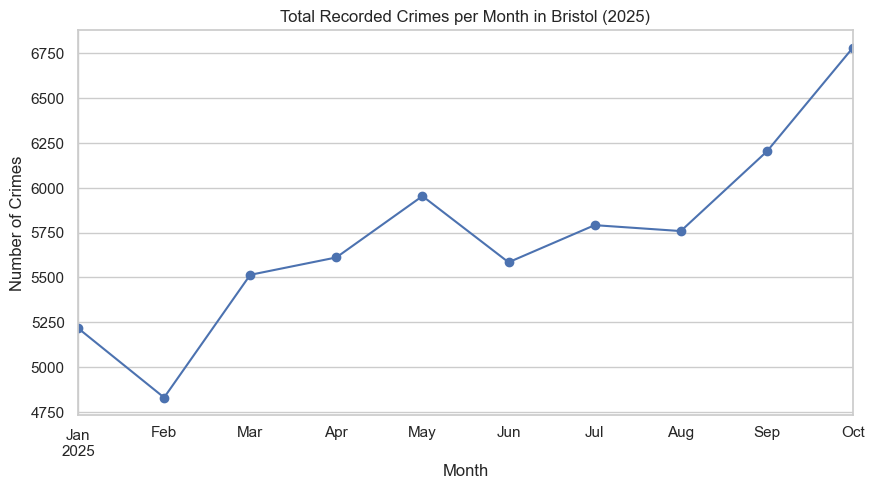

In [38]:
ax = monthly_crime.plot(
    kind="line",
    marker="o",
    figsize=(10,5),
    title="Total Recorded Crimes per Month in Bristol (2025)",
    ylabel="Number of Crimes",
    xlabel="Month"
)


### Crime Type Distribution

<Axes: title={'center': 'Top 10 Crime Types in Bristol (Jan–Oct 2025)'}, xlabel='Crime type', ylabel='Number of Crimes'>

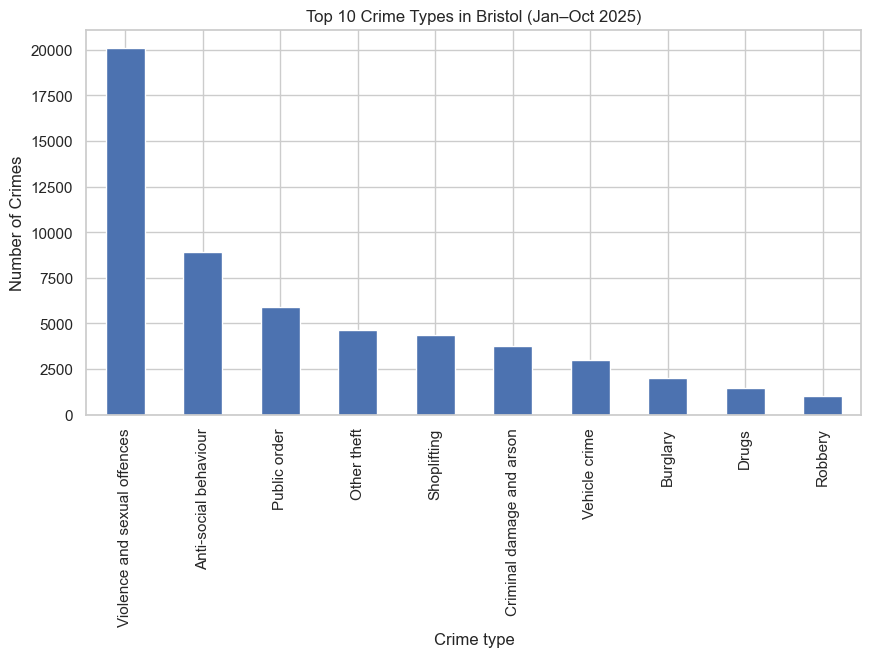

In [39]:
crime_types = bristol_crime_df["Crime type"].value_counts()
crime_types
crime_types.head(10).plot(
    kind="bar",
    figsize=(10,5),
    title="Top 10 Crime Types in Bristol (Jan–Oct 2025)",
    ylabel="Number of Crimes"
)


### Crime by LSOA (Spatial Context)

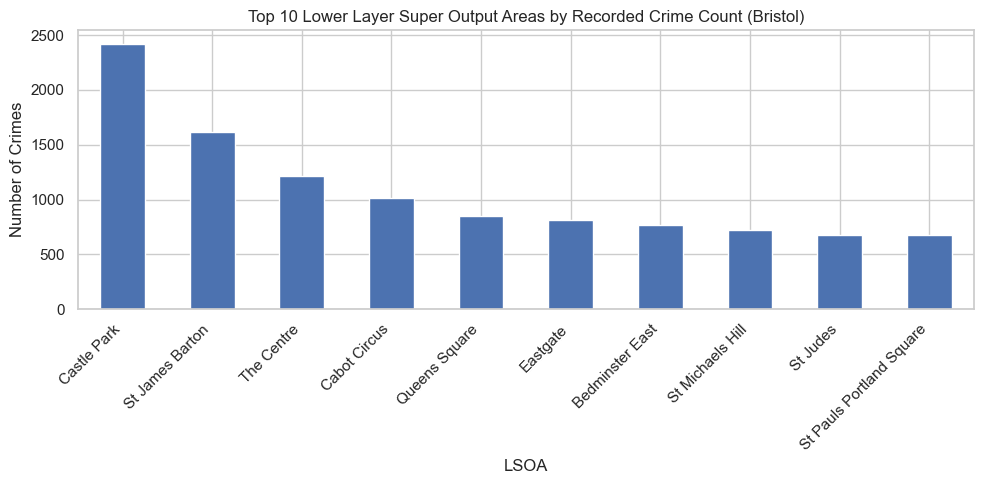

In [40]:
# 1. Count crimes by LSOA code from incident data
crime_counts = (
    bristol_crime_df
    .groupby("LSOA21CD")
    .size()
    .reset_index(name="crime_count")
)

# 2. Join LSOA long names from master_df
crime_with_names = crime_counts.merge(
    master_df[["LSOA21CD", "LSOA21LN"]],
    on="LSOA21CD",
    how="left"
)

# 3. Get top 10 LSOAs by crime count
top_10_lsoas = (
    crime_with_names
    .sort_values("crime_count", ascending=False)
    .head(10)
)

# 4. Plot the chart
ax = top_10_lsoas.plot(
    kind="bar",
    x="LSOA21LN",
    y="crime_count",
    figsize=(10,5),
    legend=False
)

ax.set_title("Top 10 Lower Layer Super Output Areas by Recorded Crime Count (Bristol)")
ax.set_xlabel("LSOA")
ax.set_ylabel("Number of Crimes")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()




### . Prepare for Socioeconomic Analysis (Merge Check)

In [41]:
# Get the intersecting LSOA codes
common_lsoa_codes = set(bristol_crime_df["LSOA21CD"]).intersection(
    set(master_df["LSOA21CD"])
)

# Map those codes to LSOA long names
common_lsoa_names = (
    master_df[master_df["LSOA21CD"].isin(common_lsoa_codes)]
    [["LSOA21CD", "LSOA21LN"]]
    .drop_duplicates()
    .sort_values("LSOA21LN")
)

common_lsoa_names.head(10)



,LSOA21CD,LSOA21LN
35,E01014523,Allison Road
60,E01014552,Alma Road
21,E01014509,Ashley Down
6,E01014491,Ashley Hill
199,E01014700,Ashton
14,E01014501,Ashton Vale
266,E01014496,Avonmouth Docks
12,E01014499,Avonmouth Village
8,E01014493,Barrow Hill
247,E01033356,Barton Hill


### Aggregate Crime to LSOA Level

In [42]:
# Aggregate Crime Count
crime_counts = (
    bristol_crime_df
    .groupby("LSOA21CD")
    .size()
    .reset_index(name="crime_count")
)

# Merge with LSOA name table
lsoa_with_crime = (
    master_df[["LSOA21CD", "LSOA21LN"]]
    .merge(
        crime_counts,
        on="LSOA21CD",
        how="left"
    )
)

# Handle LSOAs with zero crime
lsoa_with_crime["crime_count"] = lsoa_with_crime["crime_count"].fillna(0).astype(int)

lsoa_with_crime.head(10)

,LSOA21CD,LSOA21LN,crime_count
0,E01014674,Burchells Green,147
1,E01014485,Mina Road,208
2,E01014486,St Agnes,383
3,E01014487,Cromwell Road,80
4,E01014488,Upper Montpelier,219
5,E01014489,Lower Montpelier,428
6,E01014491,Ashley Hill,144
7,E01014492,Shirehampton Centre,226
8,E01014493,Barrow Hill,179
9,E01014494,Shirehampton Portway,110


### Merge with Socioeconomic Data

In [43]:
analysis_df = lsoa_crime_counts.merge(
    master_df,
    on="LSOA21CD",
    how="left"
)
analysis_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LSOA21CD                268 non-null    object 
 1   Period_Total_Crimes_x   268 non-null    int64  
 2   LSOA21NM                268 non-null    object 
 3   LSOA21LN                268 non-null    object 
 4   IMDScore                268 non-null    float64
 5   Income                  268 non-null    float64
 6   Employment              268 non-null    float64
 7   EducationScore          268 non-null    float64
 8   CrimeScore              268 non-null    float64
 9   LivingEnvironmentScore  268 non-null    float64
 10  POP2022Total            268 non-null    int64  
 11  Period_Total_Crimes_y   268 non-null    int64  
 12  Crime_Rate              268 non-null    float64
dtypes: float64(7), int64(3), object(3)
memory usage: 27.3+ KB


## Socioeconomic EDA (Core Research Question)

### Crime Count vs Employment

In [44]:
analysis_df.columns.tolist()


['LSOA21CD',
 'Period_Total_Crimes_x',
 'LSOA21NM',
 'LSOA21LN',
 'IMDScore',
 'Income',
 'Employment',
 'EducationScore',
 'CrimeScore',
 'LivingEnvironmentScore',
 'POP2022Total',
 'Period_Total_Crimes_y',
 'Crime_Rate']

<Axes: title={'center': 'Crime Rate vs Employment Score by LSOA'}, xlabel='Employment', ylabel='Crime_Rate'>

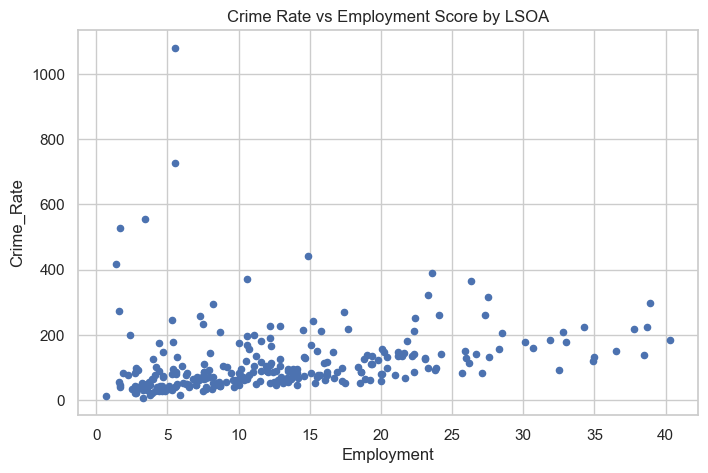

In [45]:
analysis_df.plot(
    kind="scatter",
    x="Employment",
    y="Crime_Rate",
    figsize=(8,5),
    title="Crime Rate vs Employment Score by LSOA"
)


### Crime vs Income

<Axes: title={'center': 'Crime Rate vs Income Score by LSOA'}, xlabel='Income', ylabel='Crime_Rate'>

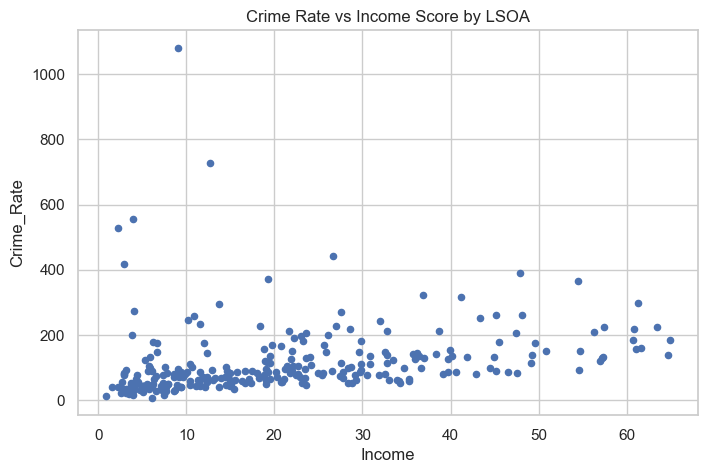

In [46]:
analysis_df.plot(
    kind="scatter",
    x="Income",
    y="Crime_Rate",
    figsize=(8,5),
    title="Crime Rate vs Income Score by LSOA"
)


### Correlation matrix

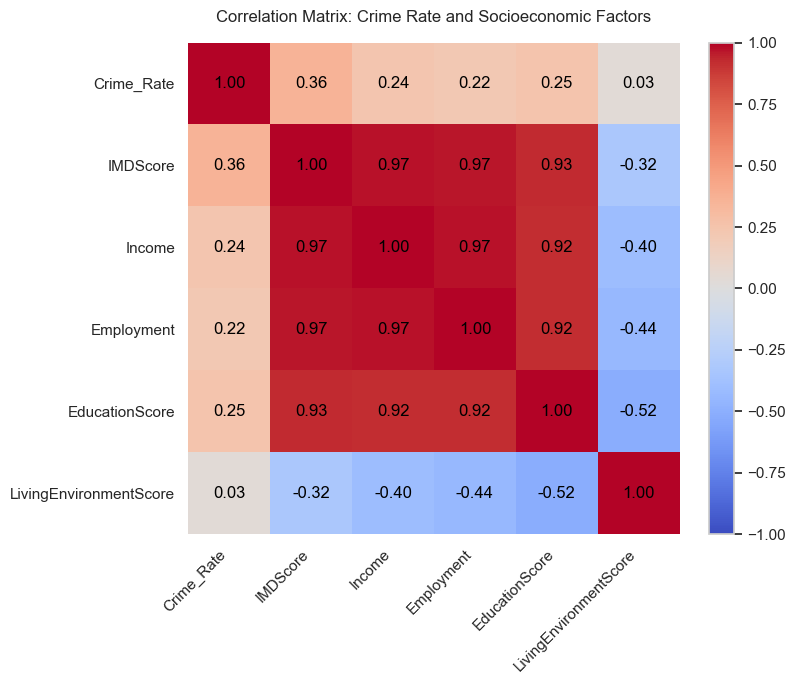

In [47]:
corr_vars = [
    "Crime_Rate",
    "IMDScore",
    "Income",
    "Employment",
    "EducationScore",
    "LivingEnvironmentScore"
]

corr = analysis_df[corr_vars].corr()

fig, ax = plt.subplots(figsize=(9,7))

cax = ax.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)

ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.columns)

ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(
            j, i,
            f"{corr.iloc[i, j]:.2f}",
            ha="center",
            va="center",
            color="black"
        )

ax.set_title("Correlation Matrix: Crime Rate and Socioeconomic Factors", pad=15)
plt.tight_layout()
plt.show()


## Additional EDAs

### Crime Rate Distribution Across LSOAs

<Axes: title={'center': 'Distribution of Crime Rates Across LSOAs'}, xlabel='Crime Rate', ylabel='Frequency'>

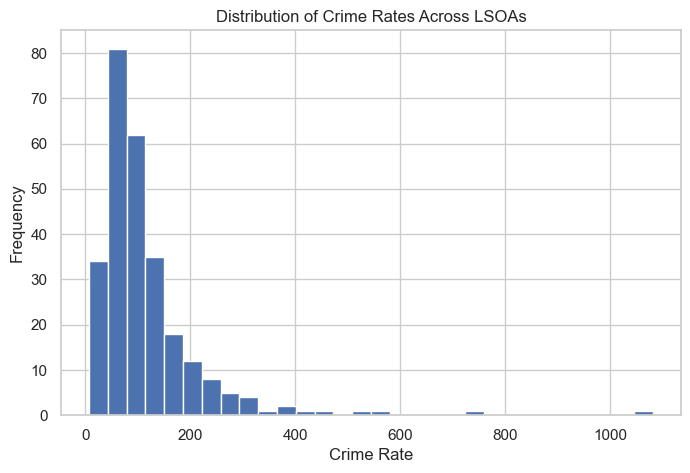

In [48]:
analysis_df["Crime_Rate"].describe()
analysis_df["Crime_Rate"].plot(
    kind="hist",
    bins=30,
    figsize=(8,5),
    title="Distribution of Crime Rates Across LSOAs",
    xlabel="Crime Rate"
)


### Crime Type Composition by High-Crime LSOAs

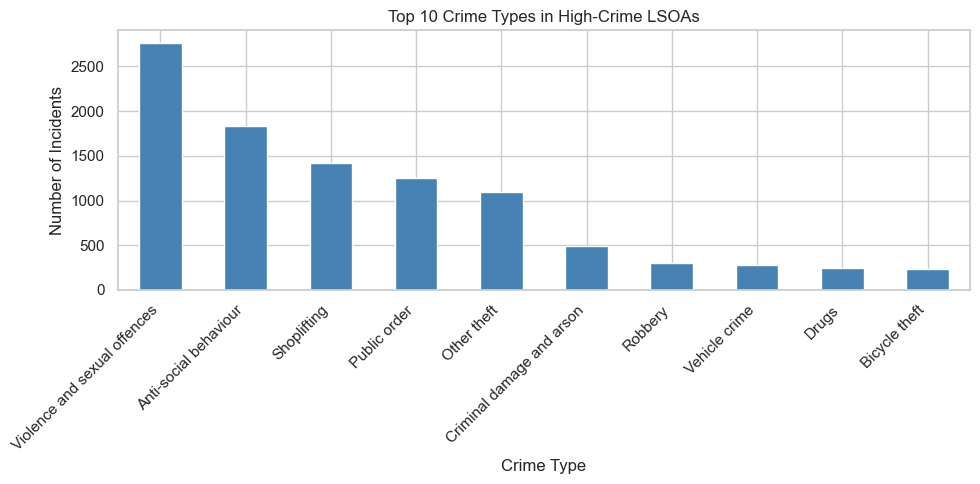

In [49]:
high_crime_lsoas = top_10["LSOA21CD"]

crime_mix = (
    bristol_crime_df[bristol_crime_df["LSOA21CD"].isin(high_crime_lsoas)]
    .groupby("Crime type")
    .size()
    .sort_values(ascending=False)
)

crime_mix_top = crime_mix.head(10)

ax = crime_mix_top.plot(
    kind="bar",
    figsize=(10,5),
    color="steelblue"
)

ax.set_title("Top 10 Crime Types in High-Crime LSOAs")
ax.set_xlabel("Crime Type")
ax.set_ylabel("Number of Incidents")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()



### Population vs Crime Count (Bias Check)

<Axes: title={'center': 'Crime Count vs Population by LSOA'}, xlabel='POP2022Total', ylabel='Period_Total_Crimes'>

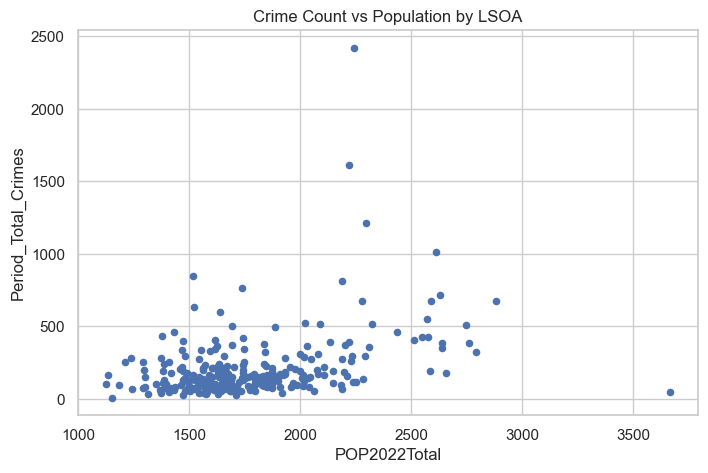

In [52]:
analysis_df = master_df.copy()


analysis_df.plot(
    kind="scatter",
    x="POP2022Total",
    y="Period_Total_Crimes", 
    figsize=(8,5),
    title="Crime Count vs Population by LSOA"
)